In [ ]:
# -*- coding: utf-8 -*-
'''
Computa els canvis registrats en el taulell de joc i ho passa al Mòdul Control.
'''
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time
import math

In [ ]:
def mostrarResultat(im,estatPartida,debug=False):
    for d in estatPartida:
        if debug:
            print(d,':',estatPartida[d])
        punts = estatPartida[d][1]
        x,y,w,h = estatPartida[d][0]
        orientacio = estatPartida[d][2]
        margin=20
        if orientacio == 0:
            x1=x-margin
            y1=y+int(h/2)
            x2=x+w
            y2=y+int(h/2)
            im =cv.putText(im,str(punts[0]),(x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1,(0,255,0),2,cv.LINE_AA)
            im =cv.putText(im,str(punts[1]),(x2,y2), cv.FONT_HERSHEY_SIMPLEX, 1,(0,255,0),2,cv.LINE_AA)
        else:
            x1=x+int(w/2)
            y1=y
            x2=x+int(w/2)
            y2=y+h+margin
            im =cv.putText(im,str(punts[0]),(x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv.LINE_AA)
            im =cv.putText(im,str(punts[1]),(x2,y2), cv.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv.LINE_AA)            
        if debug:
            im =cv.putText(im,str(d),(x+int(w/2),(y+int(h/2))), cv.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2,cv.LINE_AA)
    im.astype('uint8')
    return im

In [ ]:
def processarFrame(frame, debug=False):
    start = time.time()
    im = frame.copy()
    # Aplicar Threshold per obtenir imatge binaria
    ret,threshold = cv.threshold(frame,127,255,cv.THRESH_BINARY) 
    # Aplicar filtre Gaussia per eliminar el soroll
    threshold = cv.GaussianBlur(threshold, (5,5), 0) 
    
    # Creem imatge 2D per trobar-hi contorns 
    contorns = threshold[:,:,0]
    if debug :
        plt.figure()
        plt.imshow(contorns,'gray')
    # Trobem els contorns presents en la imatge (principalment les fitxes i els punts)
    contours, hierarchy = cv.findContours(contorns,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # contours -> Llista de contorns (llista de llistes de punts que formen cada contorn)
    # hierarchy ->Llista de relacions entre contorns
    # estructura de hierarchy -> [Next, Previous, First_Child, Parent]
    # el valor de cada camp referencia a un altre contorn
    # si no fa referencia a cap contorn, valor = -1 p.e si un contorn no te cap contorn dins : First_Child = -1
    
    # Creem un diccionari per desar les fitxes amb les seves dades
    dictContorns = {}
    # dictContorns = {idContorn: [cos,punts,orientacio]}
    #                 cos: [x, y, width, height]
    #                 punts: [puntsA, puntsB]
    #                 orientacio: 0 Horitzontal; 1 Vertical
    
    # Per cada contorn c
    for i,c in enumerate(contours):
        pare = hierarchy[0][i,3]
        # Si el contorn actual esta dins d'algun altre (es un punt)
        if pare != -1:
            # registrem les dades de la fitxa a la que pertany el punt a la variable cos
            # cos -> (x,y,width,height)
            cos = cv.boundingRect(contours[pare])
            # registrem les dades del punt actual
            x,y,w,h = cv.boundingRect(contours[i])
            punts=[0,0]
            orientacio=0
            #Comprovem l'orientacio de la fitxa i assignem el punt a un dels costats
            if cos[2] > cos[3]:
                # Horitzontal
                orientacio=0
                if x < cos[0]+int(cos[2]/2):
                    punts=[1,0] # Esquerra
                else:
                    punts=[0,1] # Dreta
            elif cos[2] < cos[3]:
                # Vertical
                orientacio=1
                if y < cos[1]+int(cos[3]/2):
                    punts=[1,0] # Superior
                else:
                    punts=[0,1] # Inferior
            else:
                print('Error!')
                pass          
            
            # Si la fitxa no existeix en el diccionari, la afegim amb totes les dades que hem recollit
            if not str(pare) in dictContorns:
                dictContorns[str(pare)]=[cos,punts,orientacio]
            # Si la fitxa si existeix, modifiquem el camp punts afegint el punt trobat al canto corresponent
            else:               
                dictContorns[str(pare)][1][0]+=punts[0]
                dictContorns[str(pare)][1][1]+=punts[1]
    if debug:
        print('Temps execució: %.3f segons' %(time.time()-start))
    return dictContorns

In [41]:
def getFirstFeatures(frame, debug=False):
    #frame = cv.imread('src/segonaFitxa.jpg')
    if debug:
        start = time.time()
    im = frame.copy()
    # Aplicar Threshold per obtenir imatge binaria
    ret,threshold = cv.threshold(frame,127,255,cv.THRESH_BINARY) 
    # Aplicar filtre Gaussia per eliminar el soroll
    threshold = cv.GaussianBlur(threshold, (5,5), 0) 

    # Creem imatge 2D per trobar-hi contorns 
    contorns = threshold[:,:,0]
    if debug :
        plt.figure()
        plt.imshow(contorns,'gray')
    # Trobem els contorns presents en la imatge (principalment les fitxes i els punts)
    contours, hierarchy = cv.findContours(contorns,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # contours -> Llista de contorns (llista de llistes de punts que formen cada contorn)
    # hierarchy ->Llista de relacions entre contorns
    # estructura de hierarchy -> [Next, Previous, First_Child, Parent]
    # el valor de cada camp referencia a un altre contorn
    # si no fa referencia a cap contorn, valor = -1 p.e si un contorn no te cap contorn dins : First_Child = -1
    #cv.imwrite('prova2222.png',contorns)
    posicio = (0,0)
    rotacioAlpha = 0.0
    midaFitxa = (0,0) #w,h
    for i,c in enumerate(contours):  
        if hierarchy[0][i,3]==-1:
            # Calculem els vertex maxim i minim i la rotacio del contorn            
            rect = cv.minAreaRect(contours[i])  
            # rect -> (center (x,y), (width, height), angle of rotation )
            # Definim la posicio de la fitxa
            posicio = rect[0]
            # Definim la mida de la fitxa
            midaFitxa = rect[1]
            # Definim la rotacio alpha de la fitxa
            rotacioAlpha = rect[2]
            '''
            #
            #
            #
            M = cv.getRotationMatrix2D((im.shape[1]/2,im.shape[0]/2),rotacioAlpha,1)
            dst = cv.warpAffine(im,M,(im.shape[1],im.shape[0]))
            #
            #
            #
            '''
    if debug :
        plt.figure()
        plt.imshow(im)
        print('Amplada: {}, Alcada: {}, Rotacio: {}'.format(midaFitxa[0],midaFitxa[1],rotacioAlpha))
        print('Temps execució: %.3f segons' %(time.time()-start))

    return (posicio,midaFitxa,rotacioAlpha)


Posicio: (224.50001525878906, 250.00003051757812)
MidaFitxa: (54.44721603393555, 105.3589096069336)
Rotacio: -45.0


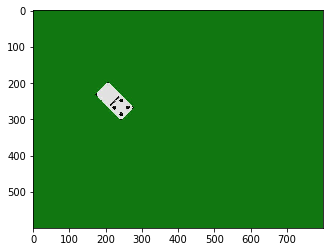

In [52]:
# -*- coding: utf-8 -*-
'''
Computa els canvis registrats en el taulell de joc i ho passa al Mòdul Control.
'''
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time
import math

if __name__ == '__main__':
    frame = cv.imread('frames/lastFrame.jpg')
    posicio,midaFitxa,rotacio = getFirstFeatures(frame)
    plt.figure()
    plt.imshow(frame)


TypeError: an integer is required (got type list)

<Figure size 432x288 with 0 Axes>

True

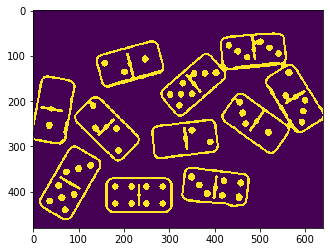

In [9]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time
import math

bg = cv.imread('src/tapete.png')
frame = cv.imread('example.jpg')
im = frame.copy()
gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
graybg = cv.cvtColor(bg,cv.COLOR_BGR2GRAY)

gray = cv.subtract(gray,graybg)
gray = cv.GaussianBlur(gray, (5,5),0)
#ret,threshold = cv.threshold(gray,100,255,cv.THRESH_BINARY) 
threshold = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,11,2)

kernel6 = np.array([
    [0,0,1,1,0,0],
    [0,1,1,1,1,0],
    [1,1,1,1,1,1],
    [1,1,1,1,1,1],
    [0,1,1,1,1,0],
    [0,0,1,1,0,0]],dtype=np.uint8)

kernel5 = np.array([
    [0,0,1,0,0],
    [0,1,1,1,0],
    [1,1,-1,1,1],
    [0,1,1,1,0],
    [0,0,1,0,0]],dtype=np.uint8)

kernel4 = np.array([
    [0,0,0,0],
    [0,1,1,0],
    [0,1,1,0],
    [0,0,0,0]],dtype=np.uint8)

kernel3 = np.array([
    [0,0,0],
    [0,1,0],
    [0,0,0]],dtype=np.uint8)

hitOrMissKernel = np.array([
    [1,0,1],
    [1,1,1],
    [0,1,0]],np.uint8)



'''
#out = cv.dilate(threshold,kernel4,iterations=2)
out = cv.erode(threshold,kernel4,iterations=2)

#out = cv.morphologyEx(out, cv.MORPH_HITMISS, hitOrMissKernel, iterations= 1)
#out = cv.medianBlur(out,3)
out = cv.morphologyEx(out, cv.MORPH_CLOSE, kernel)
#out = cv.erode(threshold,kernel3,iterations=1)
#out =out - cv.morphologyEx(out, cv.MORPH_HITMISS, hitOrMissKernel, iterations= 1)
out.astype(np.uint8)
plt.figure()
plt.imshow(out)
cv.imwrite('closing.jpg',out)
'''
kernel=np.ones((3,3),np.uint8)
out=threshold

out = cv.morphologyEx(out, cv.MORPH_CLOSE, kernel, iterations = 2)
out = cv.medianBlur(out, 7)







out.astype(np.uint8)
plt.figure()
plt.imshow(out)
cv.imwrite('closing.jpg',out)

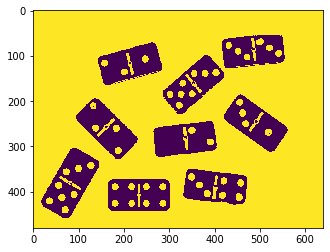

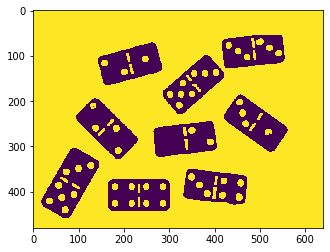

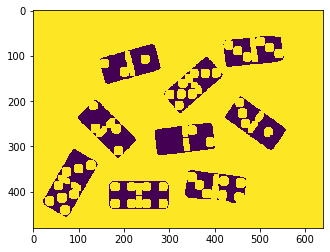

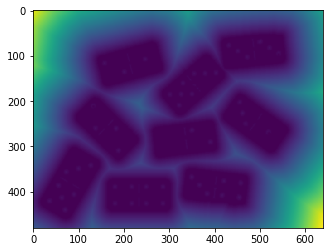

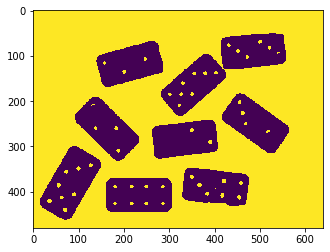

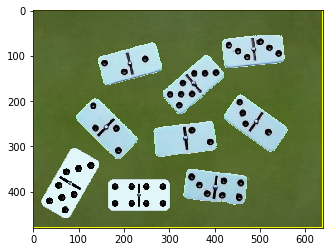

In [34]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import math

img = cv2.imread('example.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.figure()
plt.imshow(thresh)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
plt.figure()
plt.imshow(opening)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.figure()
plt.imshow(sure_bg)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

ret, sure_fg = cv2.threshold(dist_transform,0.02*dist_transform.max(),255,0)
plt.figure()
plt.imshow(dist_transform)




# Finding unknown region
sure_fg = np.uint8(sure_fg)

plt.figure()
plt.imshow(sure_fg)
im = img.copy()
contours, hierarchy = cv.findContours(sure_fg,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for c in contours:
    im =cv2.drawContours(im,[c],0,(255,255,0),2)

unknown = cv2.subtract(sure_bg,sure_fg)


plt.figure()
plt.imshow(im)

((143.5, 219.49996948242188), (72.99998474121094, 142.99996948242188), 0.0)


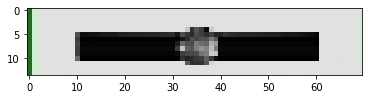

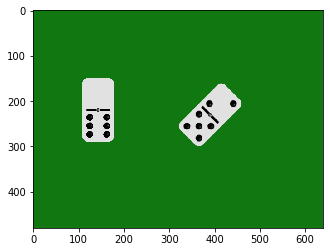

In [103]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import visio as v



frame = cv.imread('src/test1fitxa.jpg')
im = frame.copy()
rows,cols,_ = im.shape
print(v.getFirstFeatures(frame))
posicio,midaFitxa,rotacio = v.getFirstFeatures(frame)

x = int(posicio[0])
y = int(posicio[1])


width = int(midaFitxa[0])
height = int(midaFitxa[1])

centerX = int(cols/2)
centerY = int(rows/2)

h_gap = centerX - x
v_gap = centerY - y


# Traslacio al centre
M = np.float32([[1,0,h_gap],[0,1,v_gap]])
dst = cv.warpAffine(im,M,(cols,rows))

# Rotacio
if width > height:
    rotacio = 90+rotacio
else:
    temp = width
    width = height
    height = temp
    
M = cv.getRotationMatrix2D((cols/2,rows/2),rotacio,1)
dst = cv.warpAffine(dst,M,(cols,rows))

#dst = cv.circle(dst,(centerX,centerY), 5, (255,255,0), -1)



templateHeight = height*0.2
templateWidth = width*0.5

template = dst[ centerY-int(templateHeight*0.5):centerY+int(templateHeight*0.5) , centerX-int(templateWidth*0.5) : centerX+int(templateWidth*0.5)]


plt.figure()
plt.imshow(template,'gray')
plt.figure()
plt.imshow(im,'gray')


In [100]:
import cv2
cv2.__version__

'4.2.0'